In [83]:
import pandas as pd
import numpy as np
import random 
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import duckdb
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#한글 깨짐 방지지 
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [84]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [85]:
data_path = Path('../data')

train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')

target = 'support_needs'
#데이터 구조 확인
train.head()

,ID,age,gender,tenure,frequent,payment_interval,subscription_type,contract_length,after_interaction,support_needs
0,TRAIN_00000,54.0,F,47.0,22.0,8.0,member,90,25.0,0
1,TRAIN_00001,30.0,M,16.0,15.0,5.0,vip,360,23.0,0
2,TRAIN_00002,29.0,M,8.0,30.0,21.0,plus,30,21.0,0
3,TRAIN_00003,38.0,F,38.0,23.0,10.0,vip,90,6.0,0
4,TRAIN_00004,25.0,F,52.0,3.0,17.0,member,30,1.0,2


In [86]:
#EDA
train.describe()
train_cols = [col for col in train.columns if 'ID' not in col]

print(train_cols)

train['subscription_type'].value_counts()

['age', 'gender', 'tenure', 'frequent', 'payment_interval', 'subscription_type', 'contract_length', 'after_interaction', 'support_needs']


subscription_type
plus      10481
vip       10405
member     9972
Name: count, dtype: int64

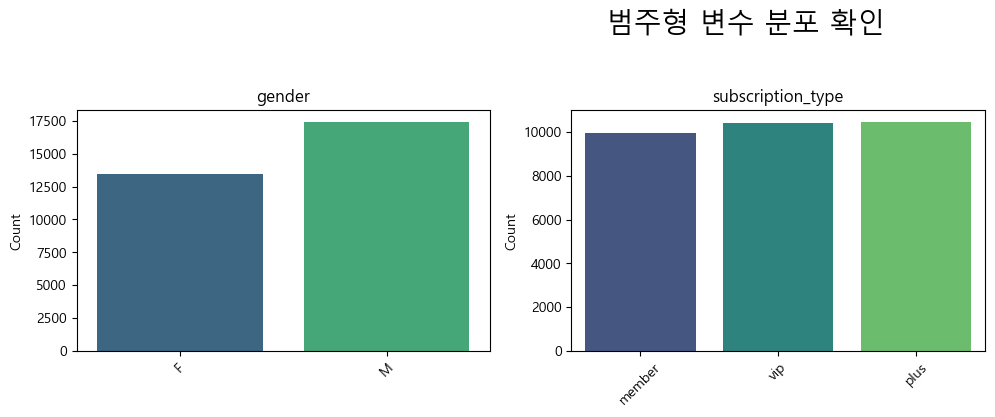

In [87]:
#범주형 변수 리스트
categorical_vars = [
    'gender', 'subscription_type', 
]

#그래프 그리기기
plt.figure(figsize=(15, 10))
plt.suptitle('범주형 변수 분포 확인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.countplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

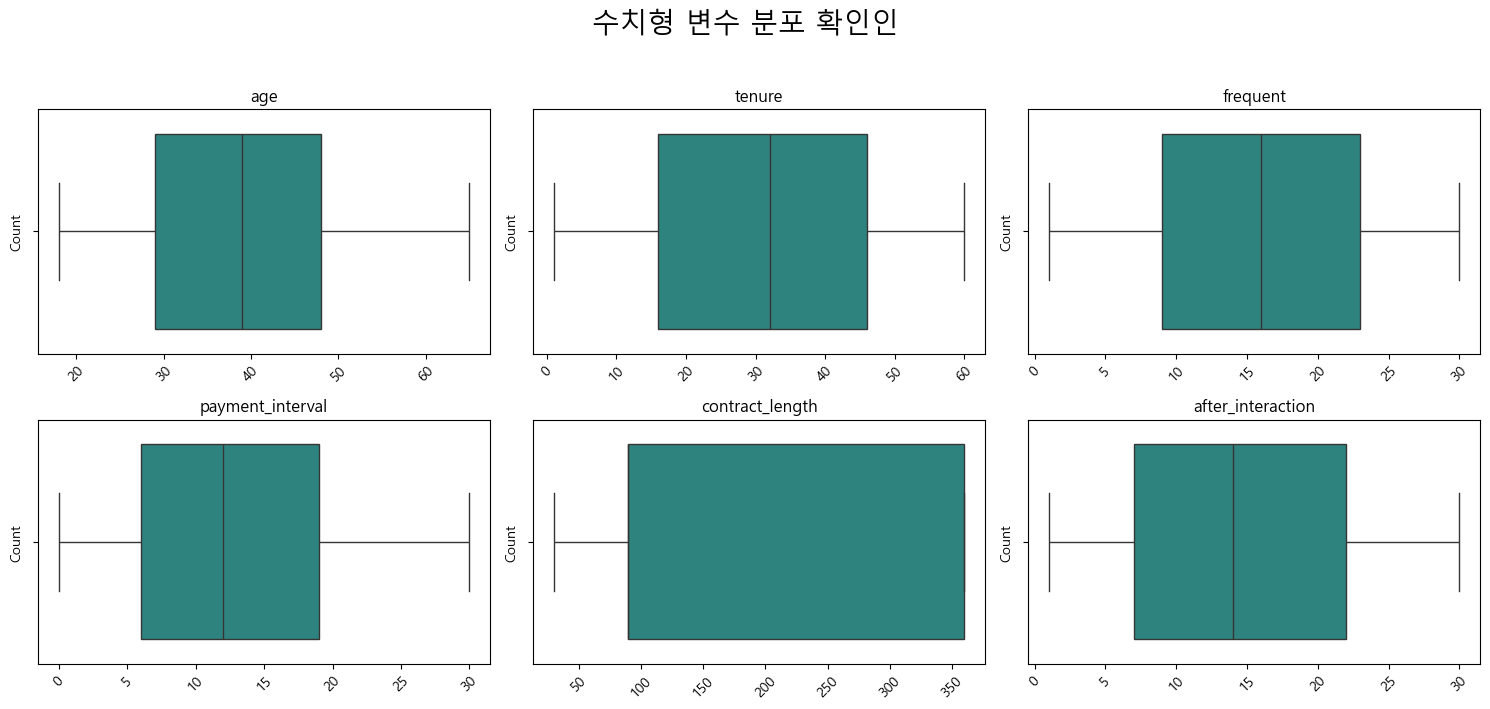

In [89]:
# 수치형 변수 리스트
numerical_vars = ['age', 'tenure', 'frequent', 'payment_interval', 'contract_length', 'after_interaction']

#그래프 그리기기
plt.figure(figsize=(15, 10))
plt.suptitle('수치형 변수 분포 확인인', fontsize=20)

# 반복문을 통해 각 변수별로 그래프 그리기
for i, var in enumerate(numerical_vars , 1):
    plt.subplot(3, 3, i) # 3x3 격자에 i번째 그래프를 그림
    sns.boxplot(x=var, data=train, palette='viridis')
    plt.title(var)
    plt.xlabel('')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])

In [ ]:
#범주형 변수 인코딩

# train['gender'] = train['gender'].map({'F':0, "M": 1})
# test['gender'] = test['gender'].map({'F':0, "M": 1})

# train['subscription_type'] = train['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})
# test['subscription_type'] = test['subscription_type'].map({'member' : 0, 'plus' : 1, 'vip' : 2})

In [ ]:
#범주형 변수 인코딩
categorical_vars = ['gender', 'subscription_type'] 
train_encoded = pd.get_dummies(train, columns=categorical_vars)
test_encoded = pd.get_dummies(test, columns=categorical_vars)


In [100]:
train_encoded.head()

,ID,age,tenure,frequent,payment_interval,contract_length,after_interaction,support_needs,gender_F,gender_M,subscription_type_member,subscription_type_plus,subscription_type_vip
0,TRAIN_00000,54.0,47.0,22.0,8.0,90,25.0,0,True,False,True,False,False
1,TRAIN_00001,30.0,16.0,15.0,5.0,360,23.0,0,False,True,False,False,True
2,TRAIN_00002,29.0,8.0,30.0,21.0,30,21.0,0,False,True,False,True,False
3,TRAIN_00003,38.0,38.0,23.0,10.0,90,6.0,0,True,False,False,False,True
4,TRAIN_00004,25.0,52.0,3.0,17.0,30,1.0,2,True,False,True,False,False


In [101]:
test_encoded.head()

,ID,age,tenure,frequent,payment_interval,contract_length,after_interaction,gender_F,gender_M,subscription_type_member,subscription_type_plus,subscription_type_vip
0,TEST_00000,18.0,40.0,6.0,15.0,30,18.0,False,True,True,False,False
1,TEST_00001,40.0,41.0,23.0,0.0,90,16.0,False,True,True,False,False
2,TEST_00002,59.0,30.0,1.0,21.0,360,25.0,True,False,True,False,False
3,TEST_00003,38.0,2.0,10.0,0.0,30,18.0,False,True,True,False,False
4,TEST_00004,30.0,28.0,21.0,20.0,360,28.0,False,True,True,False,False


In [105]:
x_train = train_encoded.drop(columns =['ID','support_needs'])
x_test = test_encoded.drop(columns = ['ID'])

y_train = train_encoded['support_needs']

In [106]:
x_train.head()

,age,tenure,frequent,payment_interval,contract_length,after_interaction,gender_F,gender_M,subscription_type_member,subscription_type_plus,subscription_type_vip
0,54.0,47.0,22.0,8.0,90,25.0,True,False,True,False,False
1,30.0,16.0,15.0,5.0,360,23.0,False,True,False,False,True
2,29.0,8.0,30.0,21.0,30,21.0,False,True,False,True,False
3,38.0,38.0,23.0,10.0,90,6.0,True,False,False,False,True
4,25.0,52.0,3.0,17.0,30,1.0,True,False,True,False,False


In [107]:
y_train.head()

0    0
1    0
2    0
3    0
4    2
Name: support_needs, dtype: int64

In [108]:
numerical_cols = ['age','tenure','payment_interval','contract_length','after_interaction',]

scaler = StandardScaler()
x_train[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = scaler.transform(x_test[numerical_cols])

In [109]:
model = LogisticRegression()
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [110]:
preds = model.predict(x_test)

In [111]:
submission = pd.read_csv(data_path/'sample_submission.csv')
submission['support_needs'] = preds

In [112]:
submission.to_csv('baseline_submit.csv', index=False)